In [1]:
import os

import torch
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from miniai.imports import *
from miniai.activations import *
from miniai.datasets import *
from miniai.diffusion import *

/home/galvanized_heart/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/galvanized_heart/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
print(f"Pytorch verions: {torch.__version__}")
print(f"Pytorch cuda version: {torch.version.cuda}")

Pytorch verions: 2.4.0+cu121
Pytorch cuda version: 12.1


In [3]:
"GPU is there" if torch.cuda.is_available() else Exception("GPU is missing") 

'GPU is there'

### Get Tiny ImageNet

In [4]:
path_t = Path("tiny_imgnet/train")
path_v = Path("tiny_imgnet/valid")

In [5]:
# Original MemmapDataset in 10_AttentionCondUNet.ipynb
class MemmapDataset(Dataset):
    def __init__(self, path, num_elems, useImg=False, useEmb=True, useLat=True,
                 img_filename="tensor_imgs.npmm" ,emb_filename="tensor_embs.npmm", lat_filename="tensor_lats.npmm", 
                 img_shape=(3,64,64), emb_shape=(768), lat_shape=(4,8,8)):

        self.num_elems = num_elems
        self.useImg = useImg
        self.useEmb = useEmb
        self.useLat = useLat

        if useImg:
            path_img = path/img_filename
            self.img_shape = (num_elems, *(img_shape))
            self.imgs = np.memmap(path_img, dtype=np.float32, mode='r', shape=self.img_shape)

        if useEmb:
            path_emb = path/emb_filename
            self.emb_shape = (num_elems, emb_shape)
            self.embs = np.memmap(path_emb, dtype=np.float32, mode='r', shape=self.emb_shape)

        if useLat:
            path_lat = path/lat_filename        
            self.lat_shape = (num_elems, *(lat_shape))
            self.lats = np.memmap(path_lat, dtype=np.float32, mode='r', shape=self.lat_shape)

    def __len__(self):
        return self.num_elems

    def __getitem__(self, i):
        return torch.tensor(self.imgs[i])

In [6]:
def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    eps = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*eps
    return (xt, t.to(device)), eps

In [7]:
def custom_collate(b):
    img = default_collate(b)
    return noisify(img)

In [8]:
def custom_dl(ds):
    return DataLoader(ds, batch_size=32, collate_fn=custom_collate, num_workers=8)

In [9]:
tds = MemmapDataset(path_t, 100_000, True, False, False)
vds = MemmapDataset(path_v, 10_000, True, False, False)

In [10]:
# Select only 64x64 fish images from the dataset
tfish = tds[:500]
vfish = vds[:50]

In [11]:
dls = DataLoaders(custom_dl(tfish), custom_dl(vfish))

In [12]:
(noised_img, timestep), true_noise = next(iter(dls.train))
noised_img.shape, timestep.shape, true_noise.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]), torch.Size([32, 3, 64, 64]))

In [13]:
class UncondUnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1, attn_chans=0, attn_start=1):
        super().__init__()

        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        
        # In Conv
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)

        # Down Blocks
        self.downs = nn.ModuleList()
        n = len(nfs)
        for i in range(n):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=n-1, num_layers=num_layers,
                                        attn_chans=0 if i<attn_start else attn_chans))
            
        # Mid Blocks
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        # Up Blocks
        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(n):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=n-1, num_layers=num_layers+1,
                                    attn_chans=0 if i>=n-attn_start else attn_chans))
            
        # Out Conv
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t = inp
        temb = timestep_embedding(t, self.n_temb)
        emb = self.emb_mlp(temb)
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)

### Train Model:
- This model is doubles filter sizes from 12_uncondunet_goldfish_v2.ipynb.
- OneCycleLR() w/ lr=1e-3.

In [14]:
def init_ddpm(model):
    for o in model.downs:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

    for o in model.ups:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

In [15]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig, clamp=True):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    x_0_hat = ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt())
    if clamp: x_0_hat = x_0_hat.clamp(-1,1)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

In [16]:
@torch.no_grad()
def sample(f, model, sz, steps, eta=1., clamp=True, progress=False):
    model.eval()
    ts = torch.linspace(1-1/steps,0,steps)
    x_t = torch.randn(sz).cuda()
    preds = []
    tbe = ts if progress else ts 
    for i,t in enumerate(tbe):
        t = t[None].cuda()
        abar_t = abar(t)
        noise = model((x_t, t))
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100), clamp=clamp)
        preds.append(x_0_hat.float().cpu())
    return preds

In [17]:
from torch.utils.tensorboard import SummaryWriter

def tensorboardfunc(hook, mod, inp, outp):
    # Initialize attributes if not already present
    if not hasattr(hook, 'stats'): 
        hook.stats = {'means': [], 'stds': [], 'dead_activations': [], 'saturated_activations': []}
    if not hasattr(hook, "iteration"):
        hook.iteration = 0
    if not hasattr(hook, "writer"):
        hook.writer =  SummaryWriter(log_dir='./logs')
    
    # Convert output to CPU
    acts = to_cpu(outp)
    
    # Log activations statistics
    hook.stats['means'].append(acts.mean().item())
    hook.stats['stds'].append(acts.std().item())
    
    # Check for dead or saturated activations
    activation_dead = (acts == 0).float().mean().item()
    activation_saturated = ((acts == 1) | (acts == -1)).float().mean().item()
    hook.stats['dead_activations'].append(activation_dead)
    hook.stats['saturated_activations'].append(activation_saturated)

    # Log weights, gradients, and activations to TensorBoard
    for name, param in mod.named_parameters():
        hook.writer.add_histogram(f"{name}.weights", param.data.cpu().numpy(), hook.iteration)
        if param.grad is not None:
            hook.writer.add_histogram(f"{name}.gradients", param.grad.cpu().numpy(), hook.iteration)
    
    hook.writer.add_histogram(f"{mod.__class__.__name__}.activations", acts.detach().cpu().numpy(), hook.iteration)
    hook.writer.add_scalar(f"{mod.__class__.__name__}.activation_mean", acts.mean().item(), hook.iteration)
    hook.writer.add_scalar(f"{mod.__class__.__name__}.activation_std", acts.std().item(), hook.iteration)
    hook.writer.add_scalar(f"{mod.__class__.__name__}.activation_dead", activation_dead, hook.iteration)
    hook.writer.add_scalar(f"{mod.__class__.__name__}.activation_saturated", activation_saturated, hook.iteration)
    
    # Update the iteration count
    hook.iteration += 1


In [20]:
lr = 1e-3
epochs = 20
opt_func = partial(optim.Adam, eps=1e-5)

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
linstats = ActivationStats(fc.risinstance((nn.BatchNorm1d, nn.SiLU, nn.Linear, nn.BatchNorm2d,
                                         nn.Identity, nn.Upsample)))
convstats = ActivationStats(fc.risinstance((nn.Conv2d)))
attnstats = ActivationStats(fc.risinstance((SelfAttention2D)))

# This callback takes a LONG time!!
"""tbcb = HooksCallback(tensorboardfunc, mod_filter=fc.risinstance((nn.BatchNorm1d, nn.SiLU, nn.Linear, nn.Conv2d, 
                                                    nn.BatchNorm2d, nn.Identity, nn.Upsample, miniai.diffusion.SelfAttention2D)))"""

cbs = [TrainCB(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), convstats, attnstats, linstats]

model = UncondUnet(in_channels=3, out_channels=3, nfs=(16,32,48,64), num_layers=1, attn_chans=8)
init_ddpm(model)

learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
1.035,0,train
0.975,0,eval
0.884,1,train
0.819,1,eval
0.614,2,train
0.475,2,eval
0.380,3,train
0.322,3,eval
0.259,4,train
0.246,4,eval


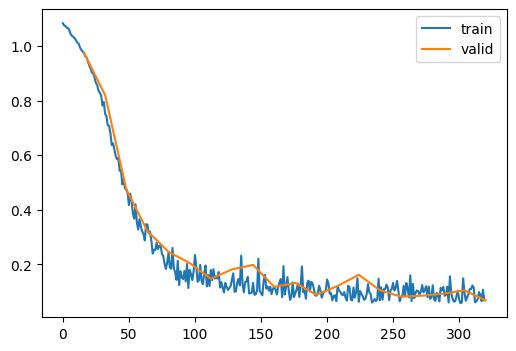

In [21]:
learn.fit(epochs)

In [22]:
preds = sample(ddim_step, model, (9, 3, 64, 64), steps=100, eta=1.)

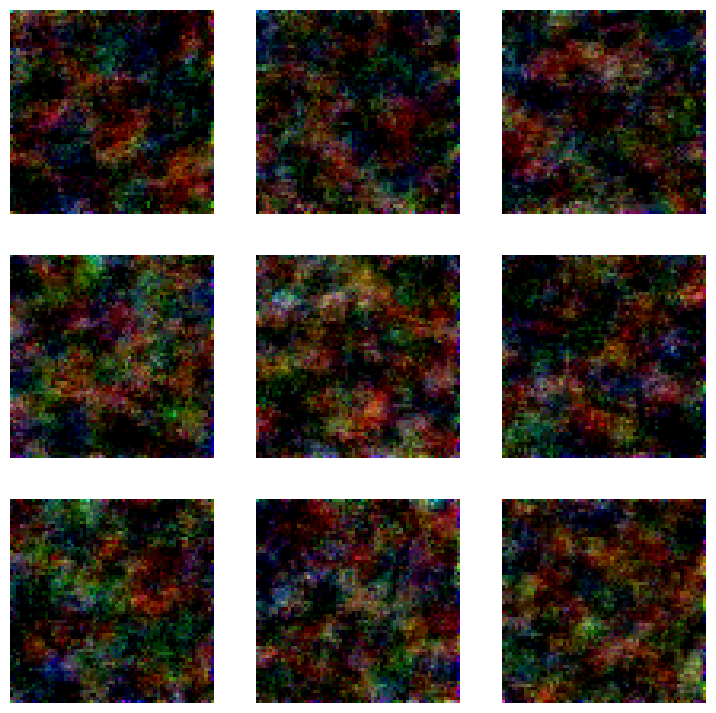

In [23]:
# Show sample output
show_images(preds[-1].clamp(0,1))

- The DDPM result is clearly different from nb 11; there seems to be more blobs that could resemble a goldfish.
- Also, it doesn't seem to resemble noise as much anymore.

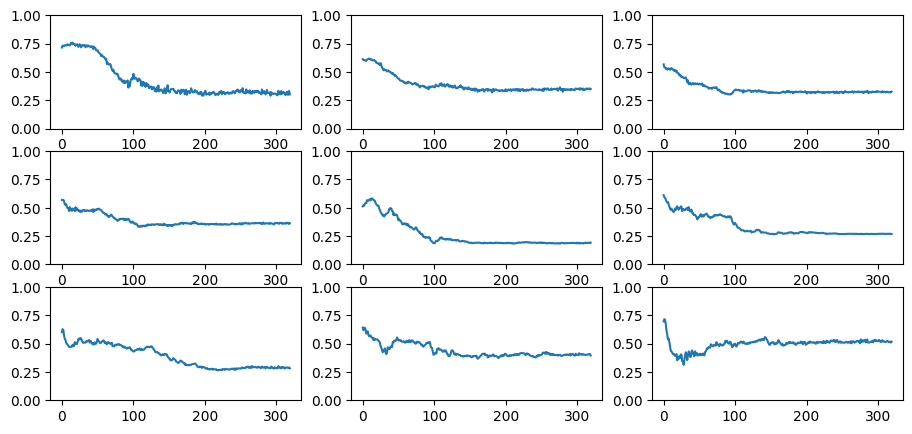

In [24]:
attnstats.dead_chart()

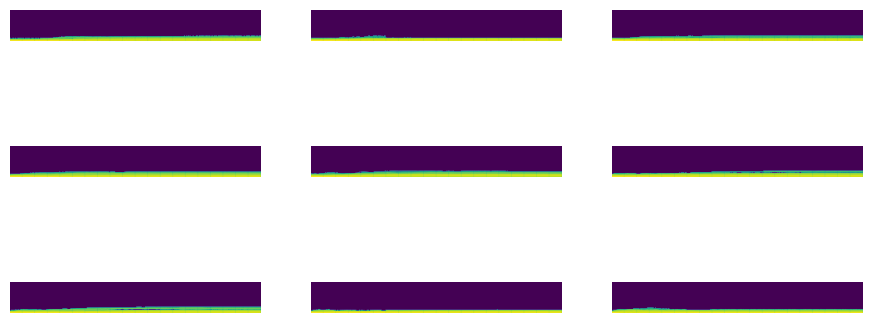

In [25]:
attnstats.color_dim()

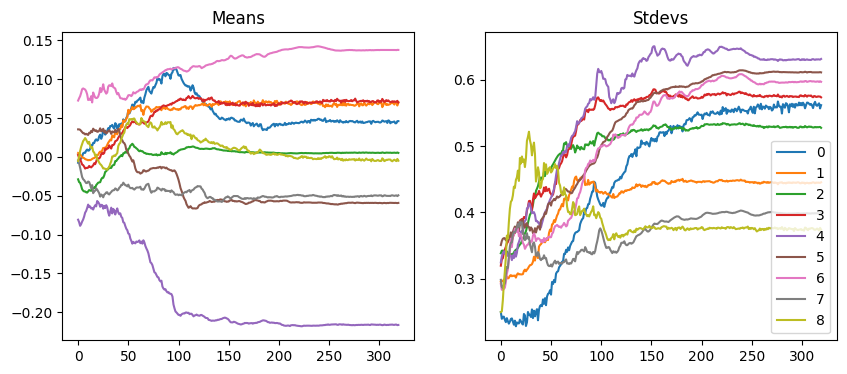

In [26]:
attnstats.plot_stats()

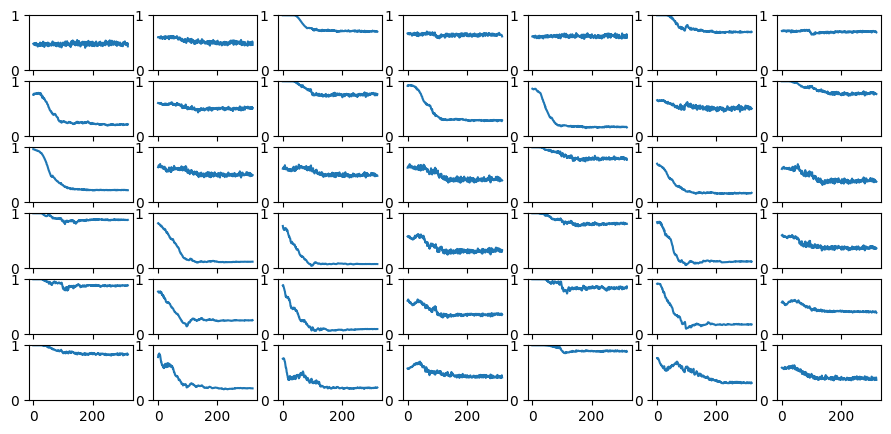

In [27]:
convstats.dead_chart()

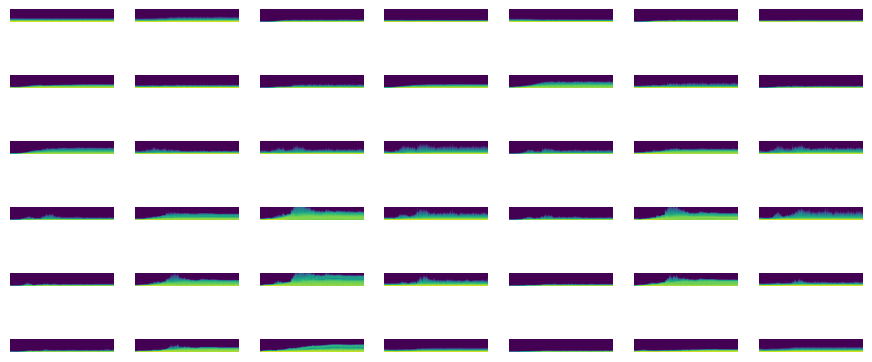

In [28]:
convstats.color_dim()

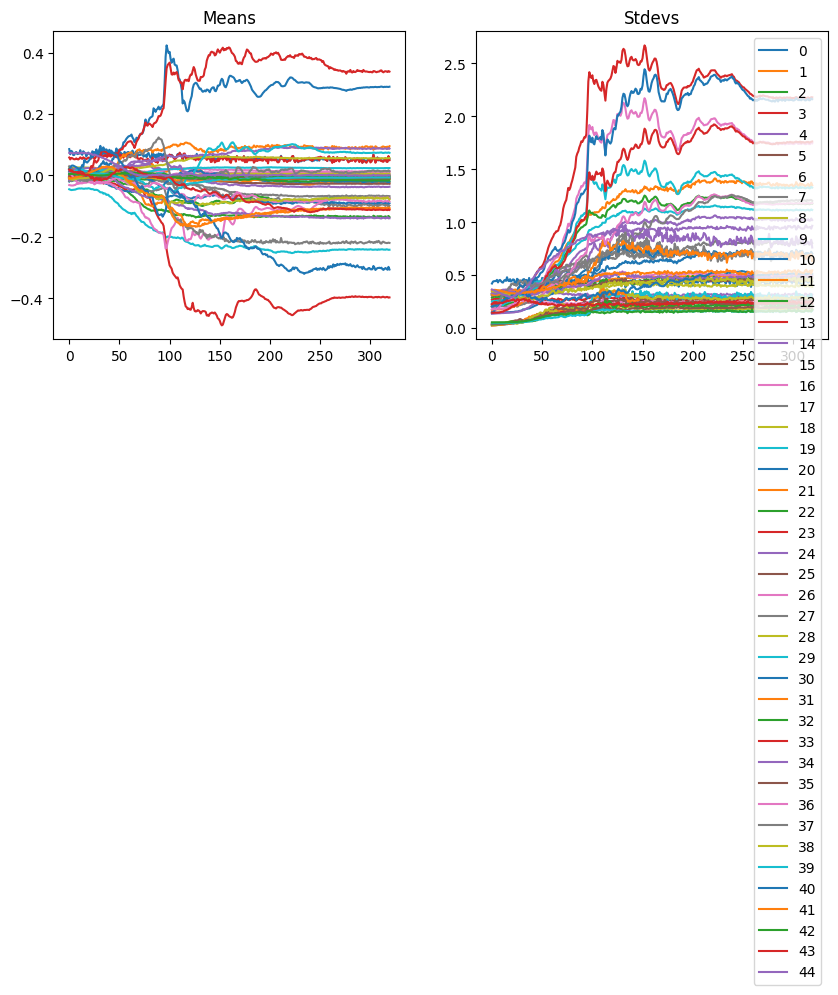

In [29]:
convstats.plot_stats()

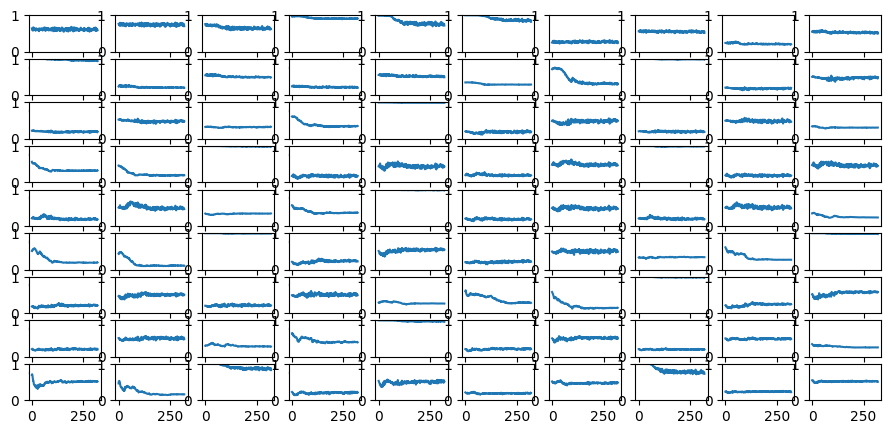

In [30]:
linstats.dead_chart()

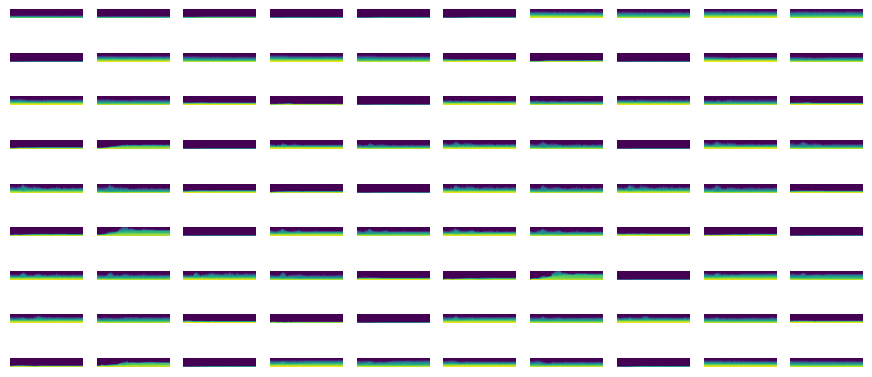

In [31]:
linstats.color_dim()

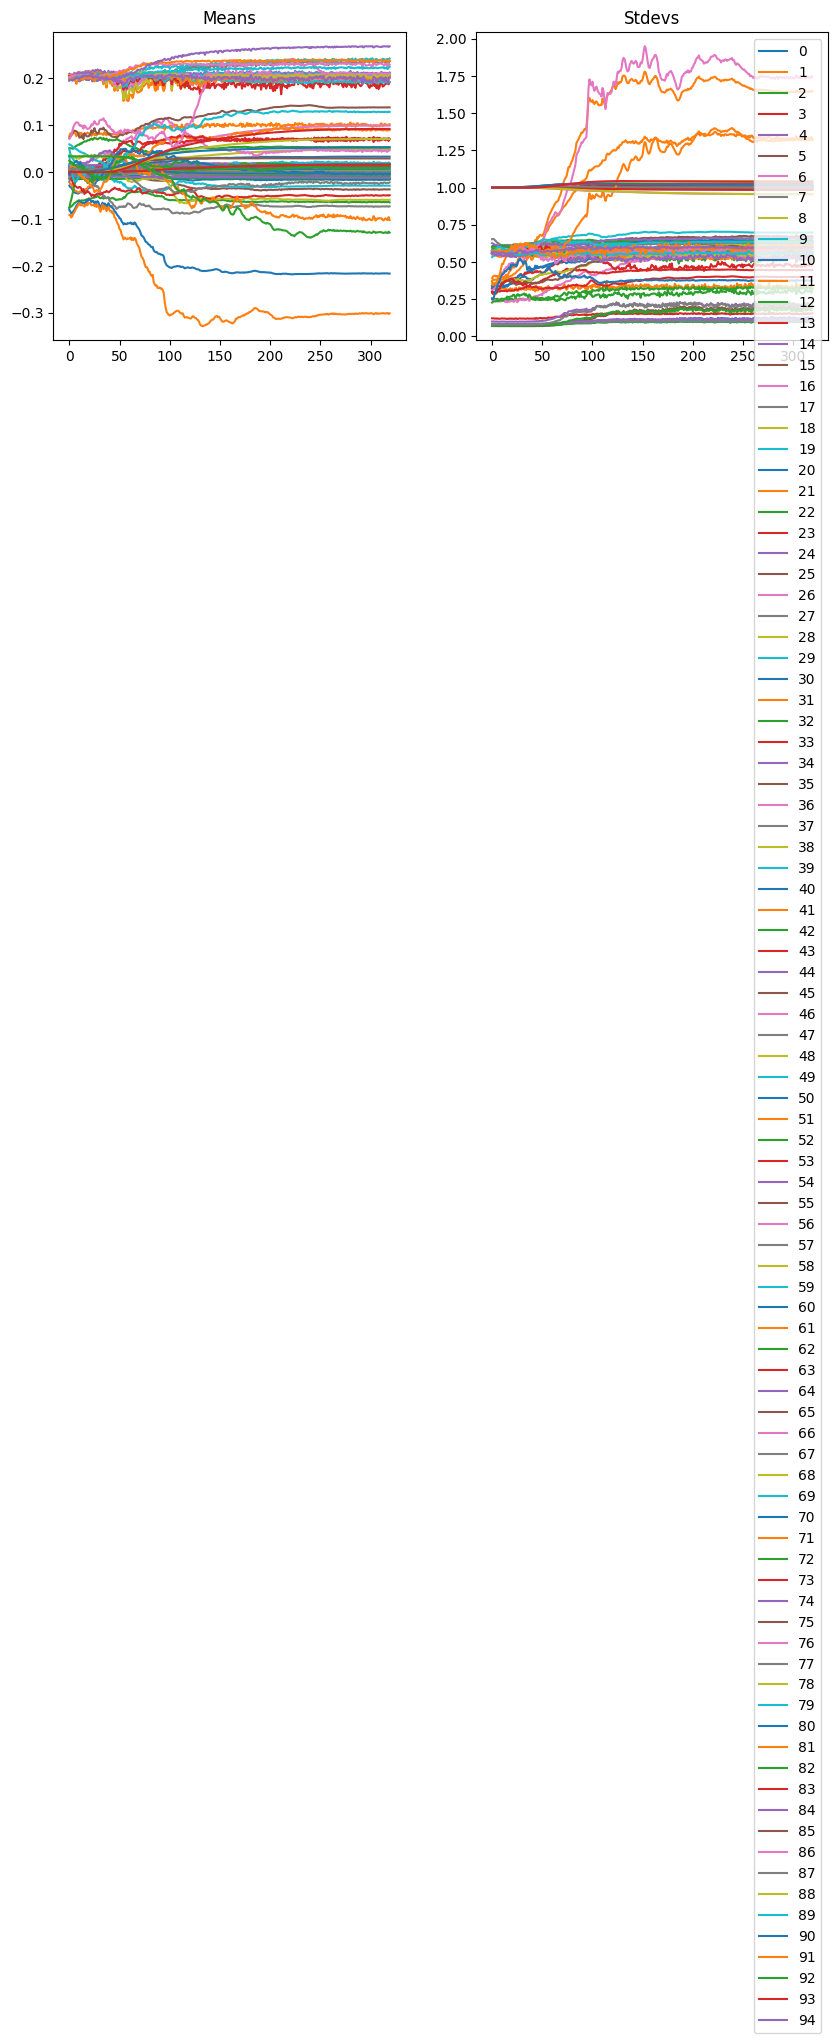

In [32]:
linstats.plot_stats()